# Intervention


In [1]:
import torch, transformer_lens, itertools
from measureLM import visualizing, decoding, patching, scoring

In [2]:
model = transformer_lens.HookedTransformer.from_pretrained("gpt2-xl").to("cpu")
model.cfg.spacing = "Ġ"
model.tokenizer.pad_token = model.tokenizer.eos_token

Using pad_token, but it is not set yet.


Loaded pretrained model gpt2-xl into HookedTransformer
Moving model to device:  cpu


### 1) Get activations

In [53]:
args = [("great","bad"), ("bright","dark"), ("positive","negative")]
prompts = [f'Q: What is the opposite of "{args[0][0]}"? A: {args[0][1]} Q: What is the opposite of "{args[1][0]}"? A: {args[1][1]} Q: What is the opposite of "{args[2][0]}"? A:']

prompts = ["Trump loves Obama. Joe Biden hates Trump"]
args = [("Trump", "Biden", "Hillary", "George", "Obama")]

#args = [("excellent","1"), ("awful","0"), ("bad","0")]
#prompts = [f'The sentiment of {args[0][0]} is {args[0][1]}. The sentiment of {args[1][0]} is {args[1][1]}. The sentiment of {args[2][0]} is']

#args = [("2*2","4"), ("4*2","8"), ("7*2","14")]
#prompts = [f'{args[0][0]} = {args[0][1]}, {args[1][0]} = {args[1][1]}, {args[2][0]} =']

#args = [("great","bad"), ("bright","dark"), ("positive","negative")]
#prompts = [f'{args[0][0]} = {args[0][1]}, {args[1][0]} = {args[1][1]}, {args[2][0]} =']

#args = [("bad","good"), ("positive","negative"), ("awesome","awful")]
#prompts = [f'The opposite of {args[0][0]} is {args[0][1]}. The opposite of {args[1][0]} is {args[1][1]}. The opposite of {args[2][0]} is']

#args = [("Julia and Romeo","friends"), ("Batman and the Joker","enemies"), ("Harry Potter and Lord Voldemord","enemies")]
#prompts = [f'Q: What is the relationship of {args[0][0]}? A: {args[0][1]} Q: What is the relationship of {args[1][0]}? A: {args[1][1]} Q: What is the relationship of {args[2][0]}? A:']



prompt 0
layer 47: [(0.0714, 'Biden'), (0.0385, 'George'), (1.0, 'Trump'), (0.5, 'Obama'), (0.2, 'Hillary')]


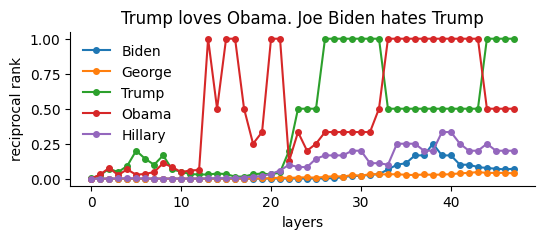

In [54]:
logits, activs, tokens = decoding.encode(prompts, model)
layer_scores = decoding.early_decoding(activs, model)
token_candidates = list(set(itertools.chain(*args)))

tok_idx = scoring.token_select(tokens, model, select_token="hates")
scored_tokens = scoring.scores_to_tokens(layer_scores, tok_idx, model, mode=token_candidates)
visualizing.visualize_token_ranks(scored_tokens, token_candidates, prompts)

### (2) Use activations to intervene

['sword', 'Ġday', 'Ġwhite']
patching blocks.25.hook_mlp_out <-- blocks.25.hook_mlp_out
patching blocks.26.hook_mlp_out <-- blocks.26.hook_mlp_out
patching blocks.27.hook_mlp_out <-- blocks.27.hook_mlp_out
patching blocks.28.hook_mlp_out <-- blocks.28.hook_mlp_out
patching blocks.29.hook_mlp_out <-- blocks.29.hook_mlp_out
patching blocks.30.hook_mlp_out <-- blocks.30.hook_mlp_out
patching blocks.31.hook_mlp_out <-- blocks.31.hook_mlp_out
patching blocks.32.hook_mlp_out <-- blocks.32.hook_mlp_out
patching blocks.33.hook_mlp_out <-- blocks.33.hook_mlp_out
patching blocks.34.hook_mlp_out <-- blocks.34.hook_mlp_out
patching blocks.35.hook_mlp_out <-- blocks.35.hook_mlp_out
patching blocks.36.hook_mlp_out <-- blocks.36.hook_mlp_out
patching blocks.37.hook_mlp_out <-- blocks.37.hook_mlp_out
patching blocks.38.hook_mlp_out <-- blocks.38.hook_mlp_out
patching blocks.39.hook_mlp_out <-- blocks.39.hook_mlp_out
patching blocks.40.hook_mlp_out <-- blocks.40.hook_mlp_out
patching blocks.41.hook_mlp_

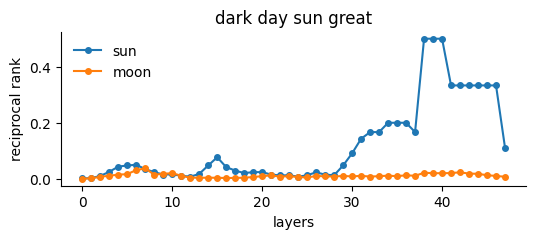

In [33]:
new_prompts = [f'dark day sun great']
#new_prompts = [f'10','-10']

new_logits, new_activs, new_tokens = decoding.encode(new_prompts, model)
pred = model.tokenizer.convert_ids_to_tokens(torch.topk(new_logits[:, -1, :], k=3).indices.tolist()[0])
print(pred)

patch_map = patching.create_hook_mapping(model, patch_l=(25, 50))

tok_idx = scoring.token_select(new_tokens, model, select_token="day")
patch_logits, resid_post = patching.intervene(new_tokens, activs, model, patch_map, extract_tok_idx=tok_idx)
resid_layer_scores = decoding.early_decoding(resid_post, model)

pred = model.tokenizer.convert_ids_to_tokens(torch.topk(patch_logits[:, -1, :], k=3).indices.tolist()[0])
print(pred)

new_token_candidates = ["sun", "moon"]

## scoring
tok_idx = scoring.token_select(new_tokens, model)
scored_tokens = scoring.scores_to_tokens(resid_layer_scores, tok_idx, model, mode=new_token_candidates)
visualizing.visualize_token_ranks(scored_tokens, new_token_candidates, new_prompts)


In [14]:
print(dir(model))


['OV', 'QK', 'T_destination', 'W_E', 'W_E_pos', 'W_K', 'W_O', 'W_Q', 'W_U', 'W_V', 'W_in', 'W_out', 'W_pos', '__annotations__', '__call__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattr__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_apply', '_backward_hooks', '_backward_pre_hooks', '_buffers', '_call_impl', '_forward_hooks', '_forward_hooks_with_kwargs', '_forward_pre_hooks', '_forward_pre_hooks_with_kwargs', '_get_backward_hooks', '_get_backward_pre_hooks', '_get_name', '_is_full_backward_hook', '_load_from_state_dict', '_load_state_dict_post_hooks', '_load_state_dict_pre_hooks', '_maybe_warn_non_full_backward_hook', '_modules', '_named_members', '_non_persistent_buffers_set', '_parameters', '_register_loa